<h2>Brief description of the problem and data</h2>

<h3>Challenge problem</h3>
<p>The challange posed by the Kaggle competition is: given a training data set of tissue biopsy images with associated cancer positive/negative labels, train a convolutional neural network to predict whether a tissue biopsy image from a test data set is cancerous or not. To see how well the model performed, submit the image id's with the associated prediction labels to Kaggle, which will score the model predictions</p>
<p>The MLP's that will be used in the problem will be fully connected convolutional neural networks</p>
<p>Next, a description of the data sets used in this problem.</p>
<h3>Data description</h3>
<p>The data in this problem challange are images of tissue biopsies. Some of the images contain metastatic cancer, while others do not. Each iamge is 96x96 pixels.</p>
<p>As stated on the Kaggle competition page, the images are drawn from the PatchCamelyon data set, found at <a href='https://github.com/basveeling/pcam'>https://github.com/basveeling/pcam</a>. The PatchCamelyon data set contains 327,680 images, some of which are duplicates, while the Kaggle data set, used in this project, has all duplicate images removed.</p>


In [7]:
import pandas as pd
import numpy as np

import tensorflow as tf

import keras
from keras import layers
from keras import backend as K
from kerastuner.tuners import RandomSearch

import altair as alt

import matplotlib.pyplot as plt

import os
import sys
import json

In [46]:
path_dir_start = 'C:/Users/assignment/'
train_path = path_dir_start + "data/train"
tif_train_dir = train_path
jpeg_train_dir = path_dir_start + 'data/train_jpeg'

test_path = path_dir_start +  "data/test"
tif_test_dir = test_path
jpeg_test_dir = path_dir_start +  'data/test_jpeg'

In [47]:
train_labels_df = pd.read_csv(path_dir_start + 'data/train_labels.csv')
print(train_labels_df.sort_values(by=['id']).head())

labels_count = train_labels_df.groupby(by=['label']).count()
_sum = sum(labels_count.values)
_counts = labels_count.values.flatten()
_props = _counts/_sum


print( f'Number of 0 labels: {_counts[0]:,}, percent: {_props[0]}', f'Number of 1 labels: {_counts[1]:,}, percent: {_props[1]}', sep='\n', end='\n\n' )

num_train_images = len([name for name in os.listdir(train_path)])
num_test_images = len([name for name in os.listdir(test_path)])

print( f'Number of training images: {num_train_images:,}', f'Number of testing images: {num_test_images:,}', f'Fraction test / train: {num_test_images/num_train_images}', sep='\n' )

                                              id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1
16166   000020de2aa6193f4c160e398a8edea95b1da598      0
87832   00004aab08381d25d315384d646f5ce413ea24b1      0
69359   0000d563d5cfafc4e68acb7c9829258a298d9b6a      0
128953  0000da768d06b879e5754c43e2298ce48726f722      1
Number of 0 labels: 130,908, percent: 0.5949687535507329
Number of 1 labels: 89,117, percent: 0.40503124644926713



Number of training images: 220,025
Number of testing images: 57,458
Fraction test / train: 0.2611430519259175


<p>There are 220,025 images in the training data set, and 57,458 images in the test data set. In total, that is 277,483 images, with a little under 75% of them used in model training and the rest left for testing.</p>
<p>The images in training data set each have a label of 0 or 1, where 0 means 'no metastatic cancer in center of image' and 1 means 'metastatic cancer present in center of image'. Almost 60% of the images in the data set are labeled as 0, and the rest are labeled as 1.</p>

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
gpu_list = tf.config.list_physical_devices('GPU')
gpu = len(gpu_list)>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(gpu_list)

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h2>Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h2>

<p>Below is a histogram of the training images, showing the counts of images with the two labels, 0 and 1, along with the fraction each label represents of the total image set</p>

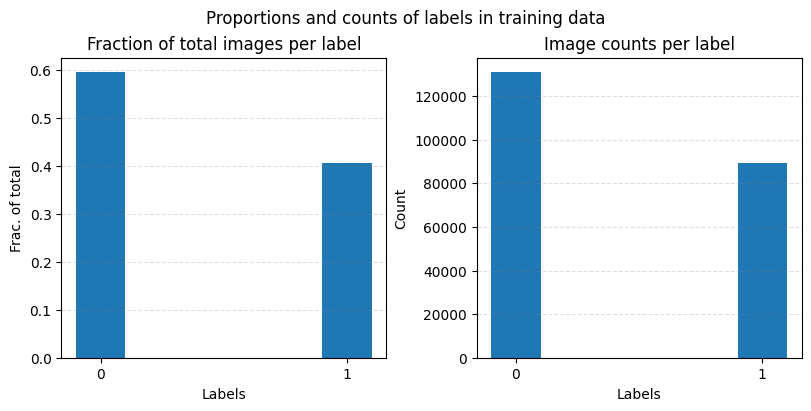

In [12]:
fig, ax = plt.subplots(1,2, figsize = (8,4), layout='constrained')
fig.suptitle('Proportions and counts of labels in training data')
ax[0].bar(["0","1"], _props, width=0.2)
ax[0].set_xlabel('Labels')
ax[0].set_ylabel('Frac. of total')
ax[0].set_title('Fraction of total images per label')
ax[0].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

ax[1].bar(["0","1"], _counts, width=0.2)
ax[1].set_xlabel('Labels')
ax[1].set_ylabel('Count')
ax[1].set_title('Image counts per label')
ax[1].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
                  
plt.show()

<p>As stated earlier, about 60% (or 130,908 out of 220,025), of the images in the training set are labeled 0, with the rest labeled 1.<p>
<p>Next lets look at the print outs of the images. First, to prepare for the model training, I will split the total training data set into model training and validation image sets. Then a sample of the model training set images will be displayed</p>

In [14]:
image_size=(96, 96)

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory=jpeg_train_dir,
    validation_split=0.2,
    image_size = image_size,
    subset="both",
    seed=1337
)

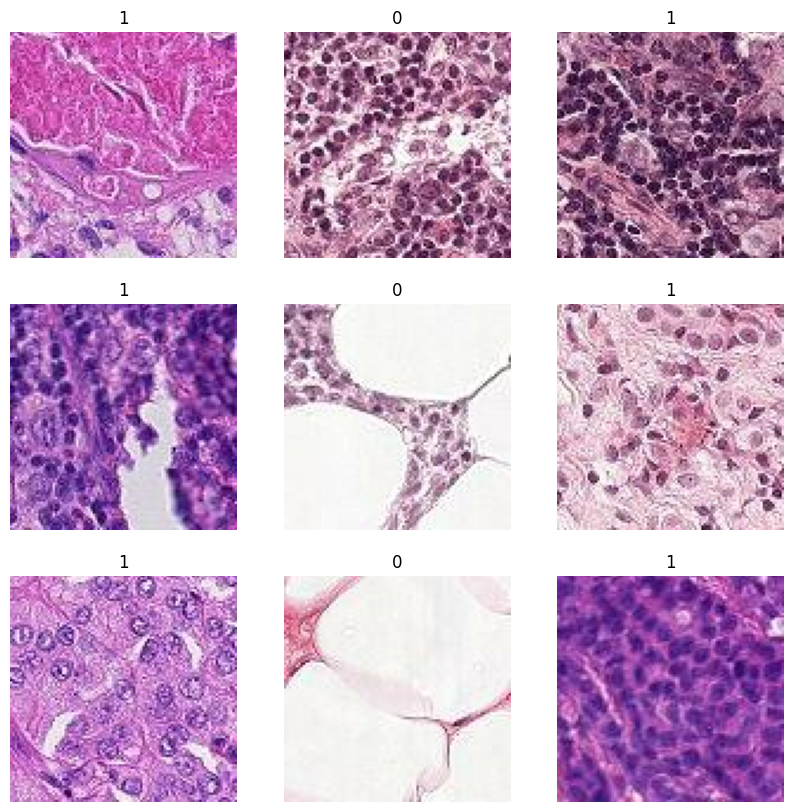

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        #print(images[i])
        ax = plt.subplot(3, 3, i + 1)
        #print(np.squeeze(images[i]).shape)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

<p>Here we have some of the images from the model training set. As I am not qualified to comment in detail on such images, I will leave it at that.</p>

<p>Beyond simply counting the number of images with each label and showcasing a few photos from the data sets, there are no more opportunities for EDA. There is only the images themselves and the labels assigned to the testing images. All images are the same dimensions, 96 px x 96 px. There are also no opportunities to clean the data, as they are comprised solely of images.</p>
<p>Given the above reasoning, I'll move onto the different model architectures and hyperparameters than will be used in addressing the challange problem.</p>

<h2>Model Architecture</h2>

<h3>Architecture Outline</h3>
<p>As stated in the class videos and slides, the larger and more diverse a data set is, the more benificial layers are. For CNN's used for image classification, that means that more layers likely leads to more accuracy in classification.  Given the the data set has over 200,000 in the training set and over 50,00 in the testing data set, a deeper model architecture will probabably be best. That said, I will also test more shallow architectures as well.</p>
<p>Here I will test three seperate but similar architectures, all of the same overall structure as described in class, which is two convolution layers followed by a pooling layer. Every convolution layer will have a Relu activation function, and every model will have an output layer with the softmax activation function.</p>
<p>The first model will have the layers:</p>
<ul>
<li>Conv2D</li>
<li>Conv2D</li>
<li>MaxPooling2D</li>
<li>GlobalAveragePooling2D</li>
<li>Dropout</li>
</ul>
<p>The second model will have the layers:</p>
<ul>
<li>Conv2D</li>
<li>Conv2D</li>
<li>MaxPooling2D</li>
<li>Conv2D</li>
<li>Conv2D</li>
<li>MaxPooling2D</li>
<li>GlobalAveragePooling2D</li>
<li>Dropout</li>
</ul>
<p>The Third model will have the layers:</p>
<ul>
<li>Conv2D</li>
<li>Conv2D</li>
<li>MaxPooling2D</li>
<li>Conv2D</li>
<li>Conv2D</li>
<li>MaxPooling2D</li>
<li>Conv2D</li>
<li>Conv2D</li>
<li>MaxPooling2D</li>
<li>GlobalAveragePooling2D</li>
<li>Dropout</li>
</ul>

<h3>Hyperparameter tuning</h3>
<p>Every model architecture will have the Conv2D filter number, kernal sizes, and learning rates tuned such that the combination of parameters that produces the model with the highest validation score will be selected as best. The list below shows the values tested:</p>
<ul>
<li>Conv2D filter numbers: [32, 64, 128]</li>
<li>Conv2D kernal sizes: [(3, 3), (5, 5)]</li>
<li>Learning rates: [0.01, 0.001, 0.0001]</li>
</ul>

<h2>Results and Analysis</h2>

<h3>Define models and hyperparameter tuners</h3>
<p>As stated above, there are three model architectures that will be tested, and each architecture will have some of it's hyperparameters optimized.</p>
<p>To speed up the process of hyperparameter tuning, a single model will be trained for each set of parameters, and each model will be trained for one epoch. Whichever model, regardless of architecture and parameter set, produces the best training accuracy score will be selected as the most likely model to produce the best test results. The final model will be trained with the best architecture and hyperparameters found previously for five epochs, then used to generate predictions to pass to Kaggle for scoring.</p>

In [9]:
def make_model_1L(hp):
        
    num_classes_testing = 2
    input_shape_testing = image_size + (3,)

    hp_filters = hp.Choice("filters", [32, 64, 128])
    hp_kernal = hp.Choice("kernel_size", [3, 5])

    model = keras.Sequential(
        [
            keras.layers.Input(shape=input_shape_testing),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes_testing, activation='softmax'),
        ]
    )
    
    hp_lr = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )
    
    return model

def make_model_2L(hp):
        
    num_classes_testing = 2
    input_shape_testing = image_size + (3,)

    hp_filters = hp.Choice("filters", [32, 64, 128])
    hp_kernal = hp.Choice("kernel_size", [3, 5])

    model = keras.Sequential(
        [
            keras.layers.Input(shape=input_shape_testing),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(0.5), 
            keras.layers.Dense(num_classes_testing, activation='softmax'),
        ]
    )

    hp_lr = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )

    return model

def make_model_3L(hp):
        
    num_classes_testing = 2
    input_shape_testing = image_size + (3,)

    hp_filters = hp.Choice("filters", [32, 64, 128])
    hp_kernal = hp.Choice("kernel_size", [3, 5])

    model = keras.Sequential(
        [
            keras.layers.Input(shape=input_shape_testing),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.Conv2D(hp_filters, kernel_size=(hp_kernal, hp_kernal), activation="relu"),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dropout(0.5), 
            keras.layers.Dense(num_classes_testing, activation='softmax'),
        ]
    )
    #model_testing.summary()

    hp_lr = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])

    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )

    return model


In [10]:
dir_str = "C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment"

In [11]:
tuner_1L = RandomSearch(
    make_model_1L,
    objective='acc',
    max_trials=50,
    overwrite=False,
    executions_per_trial=1,
    directory=dir_str,
    project_name='make_model_1L')

tuner_2L = RandomSearch(
    make_model_2L,
    objective='acc',
    max_trials=50,
    overwrite=False,
    executions_per_trial=1,
    directory=dir_str,
    project_name='make_model_2L')

tuner_3L = RandomSearch(
    make_model_3L,
    objective='acc',
    max_trials=50,
    overwrite=False,
    executions_per_trial=1,
    directory=dir_str,
    project_name='make_model_3L')



Reloading Tuner from C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment\make_model_1L\tuner0.json
Reloading Tuner from C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment\make_model_2L\tuner0.json
Reloading Tuner from C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment\make_model_3L\tuner0.json


In [12]:
print('     1 layer architecture')
tuner_1L.search_space_summary()
print()
print('     2 layer architecture')
tuner_2L.search_space_summary()
print()
print('     3 layer architecture')
tuner_3L.search_space_summary()

     1 layer architecture
Search space summary
Default search space size: 3
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

     2 layer architecture
Search space summary
Default search space size: 3
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

     3 layer architecture
Search space summary
Default search space size: 3
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
learni

<h3>Run hyperparameter tuners</h3>

In [ ]:
tuner_1L.search(train_ds, epochs=1, validation_data=val_ds)
tuner_2L.search(train_ds, epochs=1, validation_data=val_ds)
tuner_3L.search(train_ds, epochs=1, validation_data=val_ds)

<h3>Analysis: print tuner summeries and plot hyper parameters with scores/losse</h3>
<p>Below are summaries of the models that achieved the highest training accuracy scores, for each model architecture.</p>

In [15]:
models_1L = tuner_1L.get_best_models(num_models=2)
best_model_1L = models_1L[0]
models_2L = tuner_2L.get_best_models(num_models=2)
best_model_2L = models_2L[0]
models_3L = tuner_3L.get_best_models(num_models=2)
best_model_3L = models_3L[0]

In [32]:
tuner_1L.results_summary(num_trials=1)
best_model_1L.summary()

Results summary
Results in C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment\make_model_1L
Showing 1 best trials
Objective(name="acc", direction="max")

Trial 16 summary
Hyperparameters:
filters: 128
kernel_size: 3
learning_rate: 0.0001
Score: 0.7735711932182312
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 128)      0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 128)              0         


In [33]:
tuner_2L.results_summary(num_trials=1)
best_model_2L.summary()

Results summary
Results in C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment\make_model_2L
Showing 1 best trials
Objective(name="acc", direction="max")

Trial 05 summary
Hyperparameters:
filters: 128
kernel_size: 5
learning_rate: 0.0001
Score: 0.7976309657096863
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 128)       409728    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       409728    


In [34]:
tuner_3L.results_summary(num_trials=1)
best_model_3L.summary()

Results summary
Results in C:/Users/kgrit/OneDrive/Documents/UC boulder Data science masters/Intro to deep learning/week 3/assignment\make_model_3L
Showing 1 best trials
Objective(name="acc", direction="max")

Trial 16 summary
Hyperparameters:
filters: 128
kernel_size: 3
learning_rate: 0.0001
Score: 0.8005226850509644
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       147584    


<p>From the print outs above, you can see that the most accuract model was the one with the most layers, the lowest learning rate, the highest number of filters and smallest kernal size. This confirms the previously made guess of deeper models making more accurate predictions.</p>
<p>Below are plots showing how each model architecture and hyperparameter set did with regards to model accuracy and loss.</p>

In [48]:
def make_dfs_for_alt(tuner_in):
    trial_list = ["%02d" % (i,) for i in range(18)]
    cols_to_get_hp = ['filters', 'kernel_size', 'learning_rate'] 
    cols_to_get_scores = ['loss', 'acc', 'val_loss', 'val_acc']

    data_for_plot = {col: [0 for i in range(18)] for col in cols_to_get_hp + cols_to_get_scores}
                    
    for ind, trial_num in enumerate(trial_list):
        trial_path = open(tuner_in.get_trial_dir(trial_id=trial_num) + '\\trial.json')
        trial_data = json.load(trial_path)

        for col in cols_to_get_hp:
            data_for_plot[col][ind] = trial_data['hyperparameters']['values'][col]
        for col in cols_to_get_scores:
            data_for_plot[col][ind] = trial_data['metrics']['metrics'][col]['observations'][0]['value'][0]

        trial_path.close()

    return pd.DataFrame(data=data_for_plot)

def print_alt(df_in):
    chart1 = alt.Chart(df_in, title="Training accuracy").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        alt.Y('acc').scale(zero=False, padding=1),
        alt.Color('filters:N').scale(zero=False),
        strokeDash='kernel_size',
    )

    chart2 = alt.Chart(df_in, title="Training loss").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        alt.Y('loss').scale(zero=False, padding=1),
        alt.Color('filters:N').scale(zero=False),
        strokeDash='kernel_size',
    )


    chart3 = alt.Chart(df_in, title="Validation accuracy").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        alt.Y('val_acc').scale(zero=False, padding=1),
        alt.Color('filters:N').scale(zero=False),
        strokeDash='kernel_size',
    )

    chart4 = alt.Chart(df_in, title="Validation loss").mark_line().encode(
        alt.X('learning_rate').scale(zero=False, type="log"),
        alt.Y('val_loss').scale(zero=False, padding=1),
        alt.Color('filters:N').scale(zero=False),
        strokeDash='kernel_size:N',
    )

    alt.vconcat((chart1 | chart2), (chart3 | chart4)).show()



In [37]:
df_1L = make_dfs_for_alt(tuner_1L)
df_2L = make_dfs_for_alt(tuner_2L)
df_3L = make_dfs_for_alt(tuner_3L)

In [50]:
#print_alt(df_1L)

![alt text](<1 layer architecture scores plots-1.png>)

<p>For models with 1 sequences of Conv2D, Conv2D, MaxPool, accuracy scores increased and model loss decreased as learning rate decreased, except for a few sets of hyperparameters. The change accuracy and loss for each set of hyperparameters appear to have a lot of variability in values reached for training accuracy and loss, but not for validation accuracy and loss. Interestingly, most models had positive trends in their change in validation accuracy score, except for filters=64 and kernel_size=5.</p>

In [52]:
#print_alt(df_2L)

![alt text](<2 layer architecture scores plots-1.png>)

<p>For models with 2 sequences of Conv2D, Conv2D, MaxPool, accuracy scores increased and model loss decreased as learning rate decreased, as for the simpler architecture. The change accuracy and loss for each set of hyperparameters appear to have less variability in values reached for each quantity. Models with smaller kernel sizes initially became more accurate as learning rate decreased, then slightly decreased in acuracy for the lowest learning rate.</p>

In [55]:
#print_alt(df_3L)

![alt text](<3 layer architecture scores plots-1.png>)

<p>Above you can see that overall, for models with three sequences of Conv2D, Conv2D, MaxPool, accuracy scores increased and model loss decreased as learning rate decreased. This was not true for each specific kernal size and filter number pair tested however. Models with kernel_size=3, except for filters=32, became more accurate as learning rate decreased but did not improve their scores much with the lowest learning rates. The others did not imporve at all at first, but quickly improved their scores with the lowest learning rate. The standout model here though is for models with 32 filters in each convolution layer. These did the worst of all models. </p>
<p>The above analysis implies that for this data set and model architectures, a high degree of abstraction (large number of filters), detail (smaller kernel sizes), and precision in weight calculations (slow learning rate) is required to capture all the details and shapes in each image to detect the presence of cancerous tumors.</p>

<h3>Train final model with optimal model architecture and hyperparameters</h3>
<p>Next we get the model that has the best accuracy, then train the model with the same hyperparameters and the full training data set. Then, once the model is trained, predictions will be made on the test data set and sent to Kaggle for scoring.</p>

In [103]:

best_hps = tuner_3L.get_best_hyperparameters()[0]
best_hps.values

model = make_model_3L(best_hps)
batch_size_final = 128
epochs_final = 10

callbacks_final = [
    keras.callbacks.ModelCheckpoint(filepath="final_model\model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True),
]

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size_final,
    epochs=epochs_final,
    callbacks=callbacks_final,
)

Epoch 1/10
5501/5501 [==============================] - 356s 65ms/step - loss: 0.4486 - acc: 0.8013 - val_loss: 0.3455 - val_acc: 0.8487
Epoch 2/10
5501/5501 [==============================] - 359s 65ms/step - loss: 0.3105 - acc: 0.8721 - val_loss: 0.3110 - val_acc: 0.8694
Epoch 3/10
5501/5501 [==============================] - 356s 65ms/step - loss: 0.2540 - acc: 0.8993 - val_loss: 0.2350 - val_acc: 0.9066
Epoch 4/10
5501/5501 [==============================] - 358s 65ms/step - loss: 0.2211 - acc: 0.9152 - val_loss: 0.2057 - val_acc: 0.9192
Epoch 5/10
5501/5501 [==============================] - 356s 65ms/step - loss: 0.1935 - acc: 0.9260 - val_loss: 0.1949 - val_acc: 0.9252
Epoch 6/10
5501/5501 [==============================] - 362s 66ms/step - loss: 0.1703 - acc: 0.9362 - val_loss: 0.2050 - val_acc: 0.9263
Epoch 7/10
5501/5501 [==============================] - 353s 64ms/step - loss: 0.1496 - acc: 0.9450 - val_loss: 0.1856 - val_acc: 0.9294
Epoch 8/10
5501/5501 [===================

In [104]:
model.save("final_model/final_model.keras")

In [138]:
test_ds = keras.utils.image_dataset_from_directory(
    directory=jpeg_test_dir,
    labels=None,
    image_size = image_size,
    seed=1337
)

Found 57458 files belonging to 1 classes.


In [ ]:
model_predictions = model.predict(test_ds)

<p>Below is the code used to generate the Kaggle submission file.</p>

In [ ]:
test_filenames = test_ds.file_paths

for i in range(len(test_filenames)):
   #print(test_filenames[i].split('\\')[1].split('.')[0])
   print(i, end='\r')
   test_filenames[i] = test_filenames[i].split('\\')[1].split('.')[0]
   
final_preds = [ int(i) for i in np.round(model_predictions[:,1]) ]
final_preds_df = pd.DataFrame(data={'id': test_filenames, 'label': final_preds})
final_preds_df.to_csv(path_or_buf='kaggle_submission.csv', index=False)

<h2>Conclusion</h2>

![alt text](<Kaggle submission score screenshot-1.png>)

<h3>Interpretation of results</h3>
<p>It seems that the optimal model found using hyperparameter tuning did very well with its training and validation data, but did no better than the flip of a coin when tested on the actual test data set. The scores given above indicate that there are significant problems with the final model used to make the predictions, given that the training and validation scores for the trained model where quite high and the prediction scores are only 50%. This could be for a number of reasons, which are explored below.</p>
<h3>Model performance helpers and impediements</h3>
<p>From the analysis of the hyperparameter tuning, it appeared that the models with the most layers, the smallest kernel size, the largest number of filters and the slowest learning rates all helped produce the best model in training. However, it is clear from the Kaggle results that this training was not translated into predictive capabilities on test data sets. This could be from a few different factors, but likely the biggest was the model architecture being too shallow. From instruction in class lectures, we saw that the best models had dozens to hundreds of layers, and each layer could be anything from fully connected to the following layer, only partially connected, or part of a parallel structure that reconnects a few layers down before continuing onto a repitition of layer pattern. Given the depth and complexity of the most successful architectures, liekyl the most significant drawback to the mmodels trained here was their minimal number of layers.</p>
<h3>Improvements for future models</h3>
<p>It is possible that the images were not properly formatted for this problem. From reading the Kaggle page for the challange problem, the instructions ask you to detect cancerous growths within the center 32x32 pixel area of each image. I assumed that leaving the images in their larger format, instead of using just the center portion, would help the model detect cancerous tumors since it would have more training opportunities to learn what is not cancerous growth. Perhaps that assumption is not correct, and it would be better to feed only the center portions of images into the model.</p>
<p>Another way that the model could have failed is that it just was not deep enough. As explained above, some of the most successful architectures are dozens to hundreds of layers deep with complex connections between the different layers. Since there are at most around 10 layers in the models trained here, more layers in the models would likely have helped improve their predictive power.</p>